In [93]:
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from tqdm import tqdm

In [94]:
train = pd.read_csv('train.csv').sort_values(by='date')
test = pd.read_csv('test.csv').sort_values(by='date')
ids = test['id']

df = pd.concat([train, test])

In [95]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.day_of_week

<Axes: xlabel='date'>

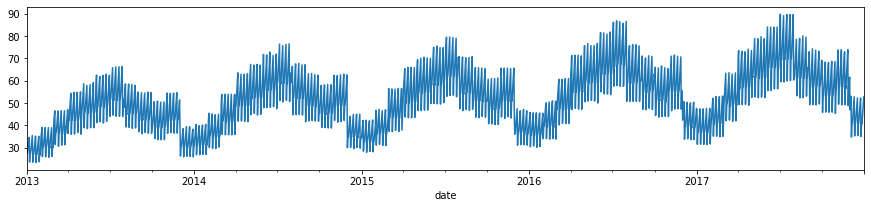

In [96]:
average_sales = df[:len(train)].groupby('date')['sales'].mean()
average_sales.plot(figsize = (15, 3))

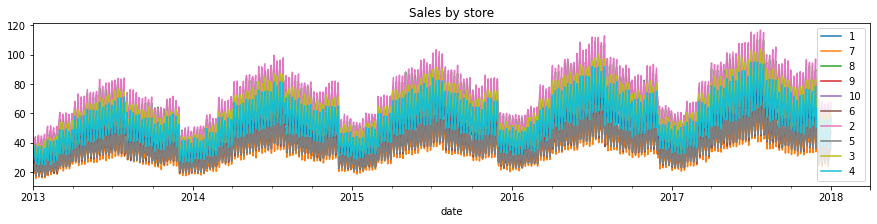

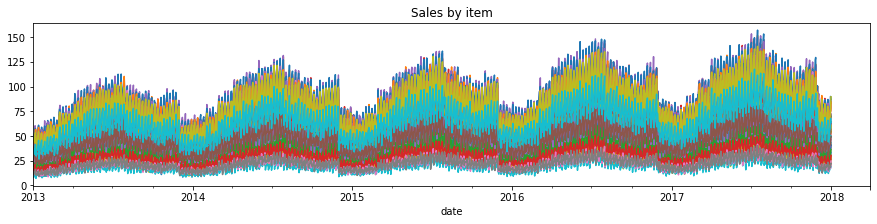

In [97]:
for country in df['store'].unique():
    ax = df[df['store'] == country][:len(train)].groupby('date')['sales'].mean().plot(figsize=(15, 3), label=country)
ax.legend()
ax.set_title("Sales by store")
plt.show()

for country in df['item'].unique():
    ax = df[df['item'] == country][:len(train)].groupby('date')['sales'].mean().plot(figsize=(15, 3), label=country)
#ax.legend()
ax.set_title("Sales by item")
plt.show()

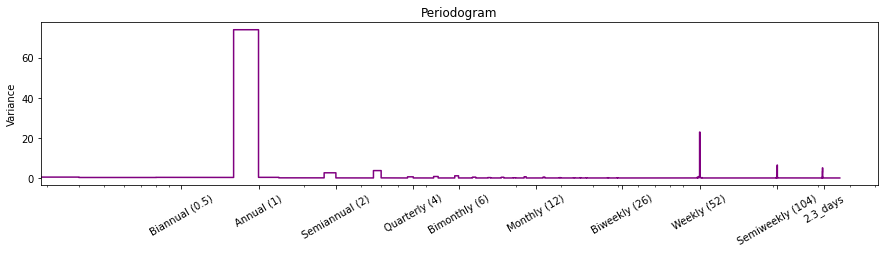

In [98]:
freqencies, spectrum = periodogram(
        average_sales,
        fs=730,
        detrend='linear',
        window="boxcar",
        scaling='spectrum',
    )

plt.figure(figsize=(15, 3))
plt.step(freqencies, spectrum, color="purple")
plt.xscale("log")
plt.xticks([1, 2, 4, 8, 12, 24, 52, 104, 208, 317],
          [
        "Biannual (0.5)",
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
        "2.3_days"
    ],rotation=30)
plt.ylabel("Variance")
plt.title("Periodogram")
plt.show()

In [99]:
dates = df['date'].unique()
days = np.arange(1, len(dates)+1)
days = pd.DataFrame({"date":dates, "Day":days})
df = df.merge(days, on="date", how="left")

In [100]:
Seasonality = dict(zip(
    (2.3, 3.5, 7, 365),
    ('2.3_days', 'Semiweek', 'Week', 'Annual')
))

for s, n in Seasonality.items():
    df[f'sin_{n}'] = np.sin(df['Day'] * (2*np.pi / s))
    df[f'cos_{n}'] = np.cos(df['Day'] * (2*np.pi / s))

In [101]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
plot_pacf(average_sales, ax=ax)
plt.show()

In [102]:
lags = [1, 2, 4, 5, 6, 7, 8, 13, 14, 15, 22, 29]
lagged = {}

In [103]:
df['lag_key'] = df[['date', 'store', 'item']].apply(lambda row: list(row), axis=1)
for i in tqdm(range(len(lags))):
    lagged[lags[i]] = df[['lag_key', 'sales']].rename(columns={'sales':f'lag_{lags[i]}'})
    lagged[lags[i]]['lag_key'] = lagged[lags[i]]['lag_key'].apply(lambda row: [row[0] + pd.Timedelta(lags[i], 'D')] + row[1:])
    lagged[lags[i]]['lag_key'] = lagged[lags[i]]['lag_key'].apply(lambda s: str(s))

df['lag_key'] = df['lag_key'].apply(lambda s: str(s))
for lag in lags:
    df = df.merge(lagged[lag], on='lag_key', how='left')

In [104]:
df.drop(columns=['id', 'lag_key'], inplace=True)
nan_head = df[df['date'] == df['date'][0] + pd.Timedelta(lags[-1], "D")].index[0]
df = df[nan_head:]
df_dummy = pd.get_dummies(df).set_index("date")

In [105]:
for i in tqdm(range(len(lags))):
    y_train = df_dummy[f'lag_{lags[i]}'].dropna()
    X_train = df_dummy.drop(columns = [f'lag_{j}' for j in lags[i:]])[:len(y_train)].drop(columns='sales')
    X_pred = df_dummy.drop(columns = [f'lag_{j}' for j in lags[i:]])[len(y_train):].drop(columns='sales')
    
    model = Ridge()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_pred)
    df_dummy[f'lag_{lags[i]}'][len(y_train):] = y_pred

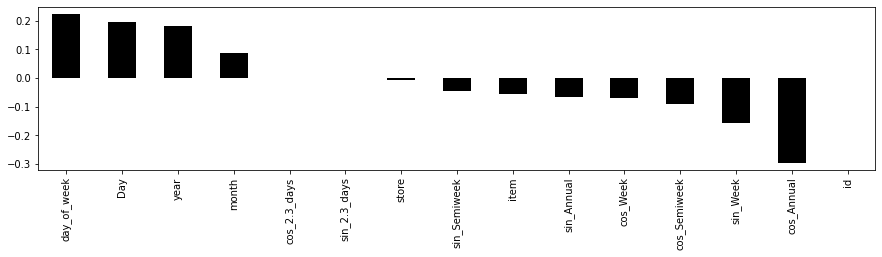

In [106]:
df_dummy.corr()['sales'].sort_values(ascending=False)[1:].plot.bar(figsize=(15,3), cmap='copper')
plt.show()

In [114]:
X_test = df_dummy[len(train)-nan_head:].drop(columns='sales')
df_train = df_dummy[:len(train)-nan_head]

In [115]:
from sklearn.preprocessing import StandardScaler

X = df_train.drop(columns='sales')
y = df_train['sales']

features = X.columns.values
dates = X.index.values

n = len(X)
p = 0.9
X_train = X[:int(p*n)]
X_valid = X[int(p*n):]
y_train = y[:int(p*n)]
y_valid = y[int(p*n):]

In [81]:
model = XGBRegressor()
model.fit(X_train, y_train)

print("XGB Training error: ", model.score(X_train, y_train))
print("XGB Test error: ", model.score(X_valid, y_valid))

model_ridge = Ridge()
model_ridge.fit(X_train, y_train)

print("\nRidge Training error: ", model_ridge.score(X_train, y_train))
print("Ridge Test error: ", model_ridge.score(X_valid, y_valid))

XGB Training error:  0.9301509643327222
XGB Test error:  0.9308362135690791

Ridge Training error:  0.91309839933005
Ridge Test error:  0.9135111812477125


In [84]:
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index)

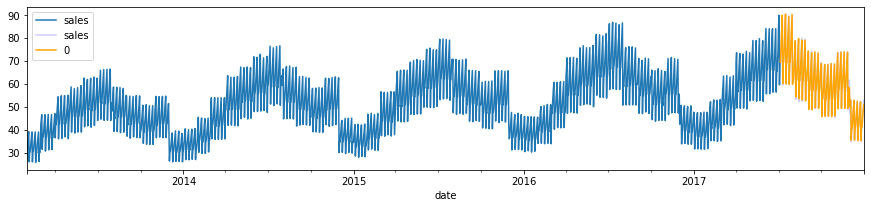

In [85]:
ax = y_train.reset_index().groupby("date").mean().plot(figsize=(15,3))
y_valid.reset_index().groupby("date").mean().plot(ax=ax, alpha=0.2, c='blue')
y_pred.reset_index().groupby("date").mean().plot(ax=ax, c='orange')
plt.show()

In [88]:
final_model = XGBRegressor()
final_model.fit(X, y)

print("Training score: ", final_model.score(X, y))

Training score:  0.9312493043125101


In [89]:
y_test_pred = pd.Series(final_model.predict(X_test), index=X_test.index)

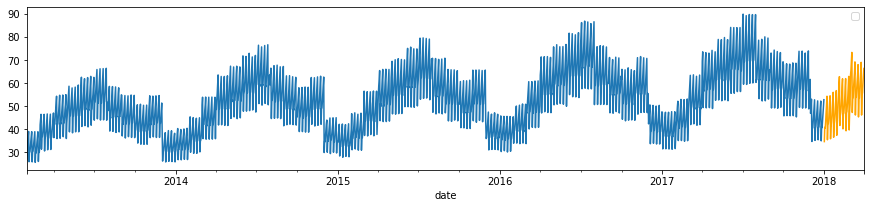

In [90]:
ax = y.reset_index().groupby("date").mean().plot(figsize=(15,3))
y_test_pred.reset_index().sort_values(by='date').groupby("date").mean().plot(ax=ax, c='orange')
ax.legend([])

In [91]:
output = pd.DataFrame({"id":ids, "sales":y_test_pred.values}).sort_values(by = "id")

In [92]:
output.to_csv("Submission.csv", index=False)